## Problem
---


Anda adalah seorang Data Analyst yang akan mengerjakan sebuah project untuk menyelesaikan permasalahan seorang client. Client Anda membutuhkan hasil analisa data yang menggunakan statistik dan dashboard visualisasi untuk membantu mereka menyelesaikan masalahnya.

---
## Objectives
---


*Pengerjaan* ini dibuat dengan tujuan sebagai berikut :

Mengembangkan model forecasting penjualan bulanan untuk memprediksi tren penjualan di masa mendatang, sehingga perusahaan dapat mengoptimalkan perencanaan stok, merancang strategi pemasaran yang lebih efektif, dan mendukung pengambilan keputusan yang berbasis data.

In [ ]:
# Package
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# Processing Data

In [ ]:
# Load data
df = pd.read_csv('Forecasting.csv')
df

,Periode_Minggu,Quantity
0,2022-12-26/2023-01-01,3
1,2023-01-02/2023-01-08,17
2,2023-01-09/2023-01-15,18
3,2023-01-16/2023-01-22,17
4,2023-01-23/2023-01-29,34
...,...,...
61,2024-02-26/2024-03-03,25
62,2024-03-04/2024-03-10,35
63,2024-03-11/2024-03-17,24
64,2024-03-18/2024-03-24,15


In [ ]:
# Rename Colums
df.rename(columns={
    'Periode_Minggu':'Date'
},inplace=True)

In [ ]:
# Ambil Hari Terakhir Column Date
def clean_date(data):
    data_split = data.split("/")
    clean = data_split[1]
    return clean
df['Date'] = df['Date'].apply(clean_date)

In [ ]:
# Set Index Menjadi Time Series
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index, yearfirst=True)
df.index

DatetimeIndex(['2023-01-01', '2023-01-08', '2023-01-15', '2023-01-22',
               '2023-01-29', '2023-02-05', '2023-02-12', '2023-02-19',
               '2023-02-26', '2023-03-05', '2023-03-12', '2023-03-19',
               '2023-03-26', '2023-04-02', '2023-04-09', '2023-04-16',
               '2023-04-23', '2023-04-30', '2023-05-07', '2023-05-14',
               '2023-05-21', '2023-05-28', '2023-06-04', '2023-06-11',
               '2023-06-18', '2023-06-25', '2023-07-02', '2023-07-09',
               '2023-07-16', '2023-07-23', '2023-07-30', '2023-08-06',
               '2023-08-13', '2023-08-20', '2023-08-27', '2023-09-03',
               '2023-09-10', '2023-09-17', '2023-09-24', '2023-10-01',
               '2023-10-08', '2023-10-15', '2023-10-22', '2023-10-29',
               '2023-11-05', '2023-11-12', '2023-11-19', '2023-11-26',
               '2023-12-03', '2023-12-10', '2023-12-17', '2023-12-24',
               '2023-12-31', '2024-01-07', '2024-01-14', '2024-01-21',
      

In [ ]:
# Ubah Freq Index
df.asfreq('W-MON')
df.index = df.index.date
df.head()

,Quantity
2023-01-01,3
2023-01-08,17
2023-01-15,18
2023-01-22,17
2023-01-29,34


In [ ]:
# Summary Data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66 entries, 2023-01-01 to 2024-03-31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Quantity  66 non-null     int64
dtypes: int64(1)
memory usage: 1.0+ KB


# Explolation Data Analysis

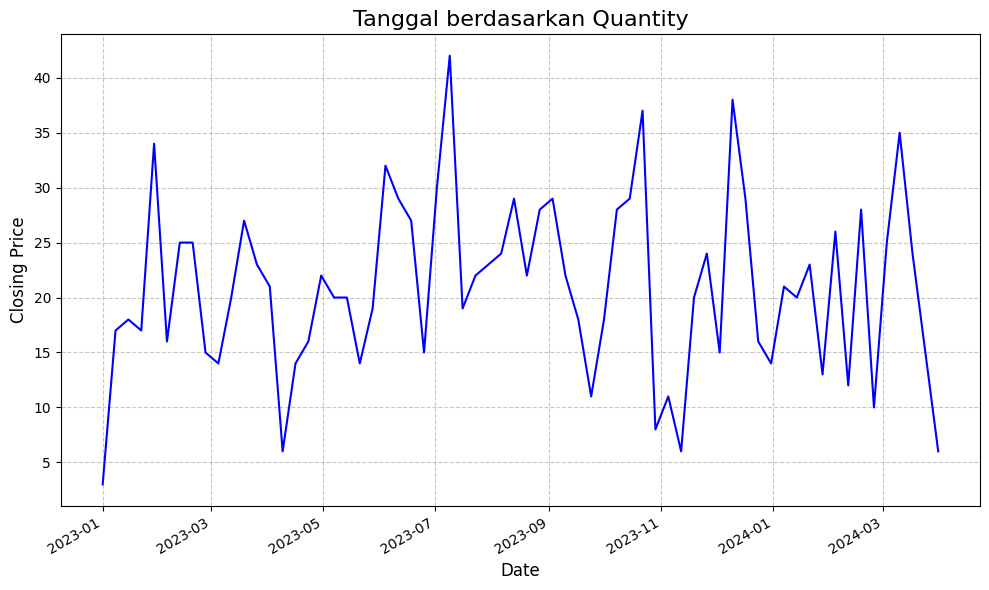

In [ ]:
# Line Chart 
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df.index, df['Quantity'], linestyle='-', color='b')
ax.set_title('Tanggal berdasarkan Quantity', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Closing Price', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

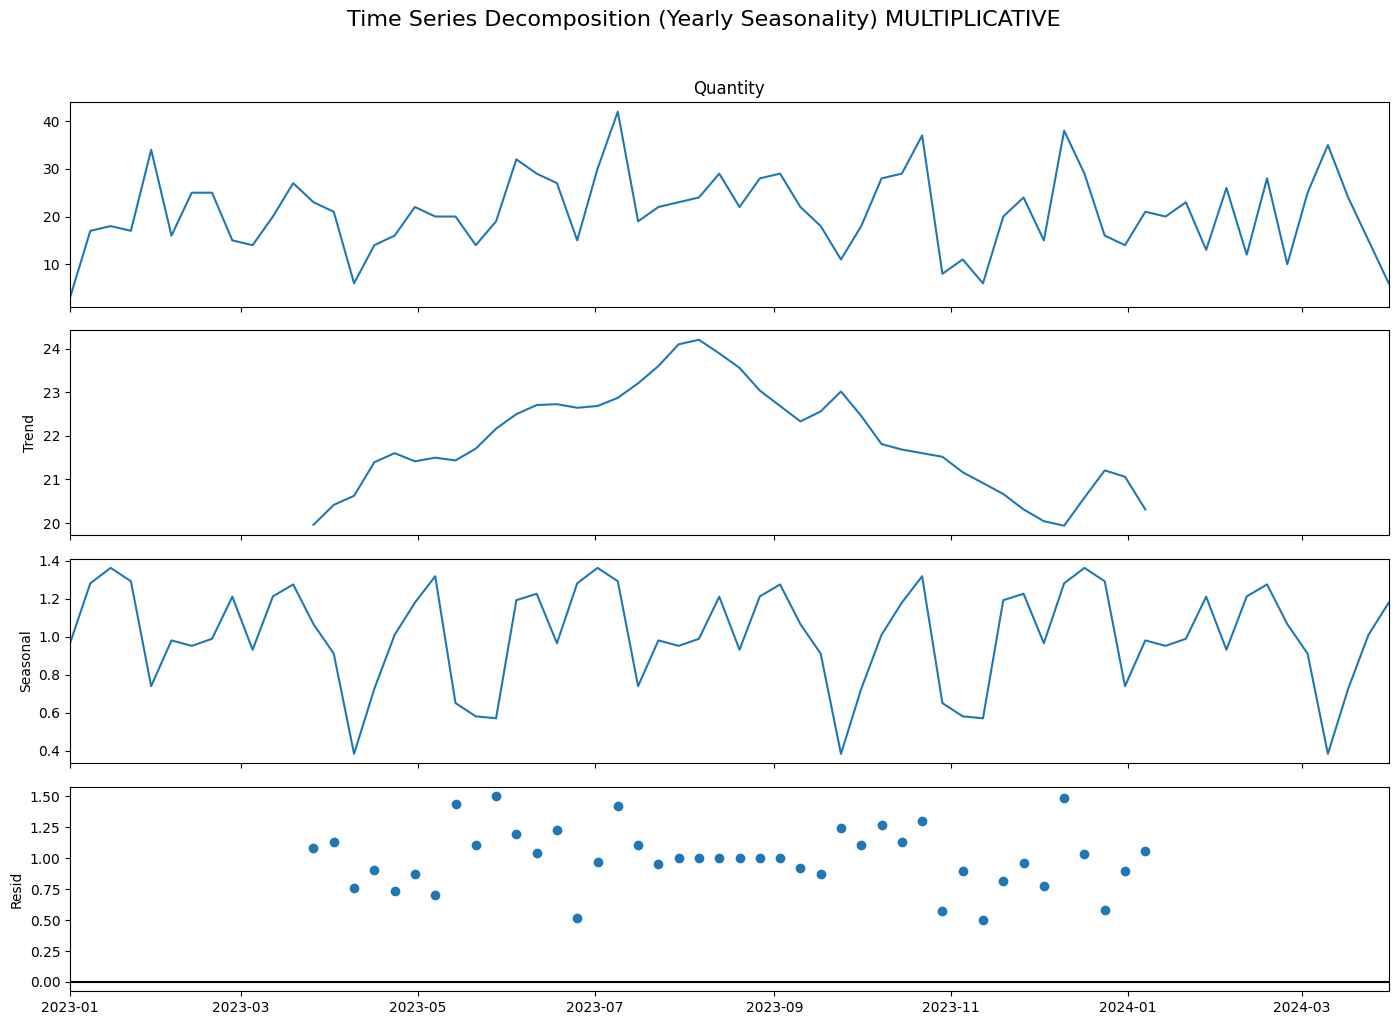

In [884]:
decomposition = seasonal_decompose(df['Quantity'], model='multiplicative', period=24)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.suptitle('Time Series Decomposition (Yearly Seasonality) MULTIPLICATIVE', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

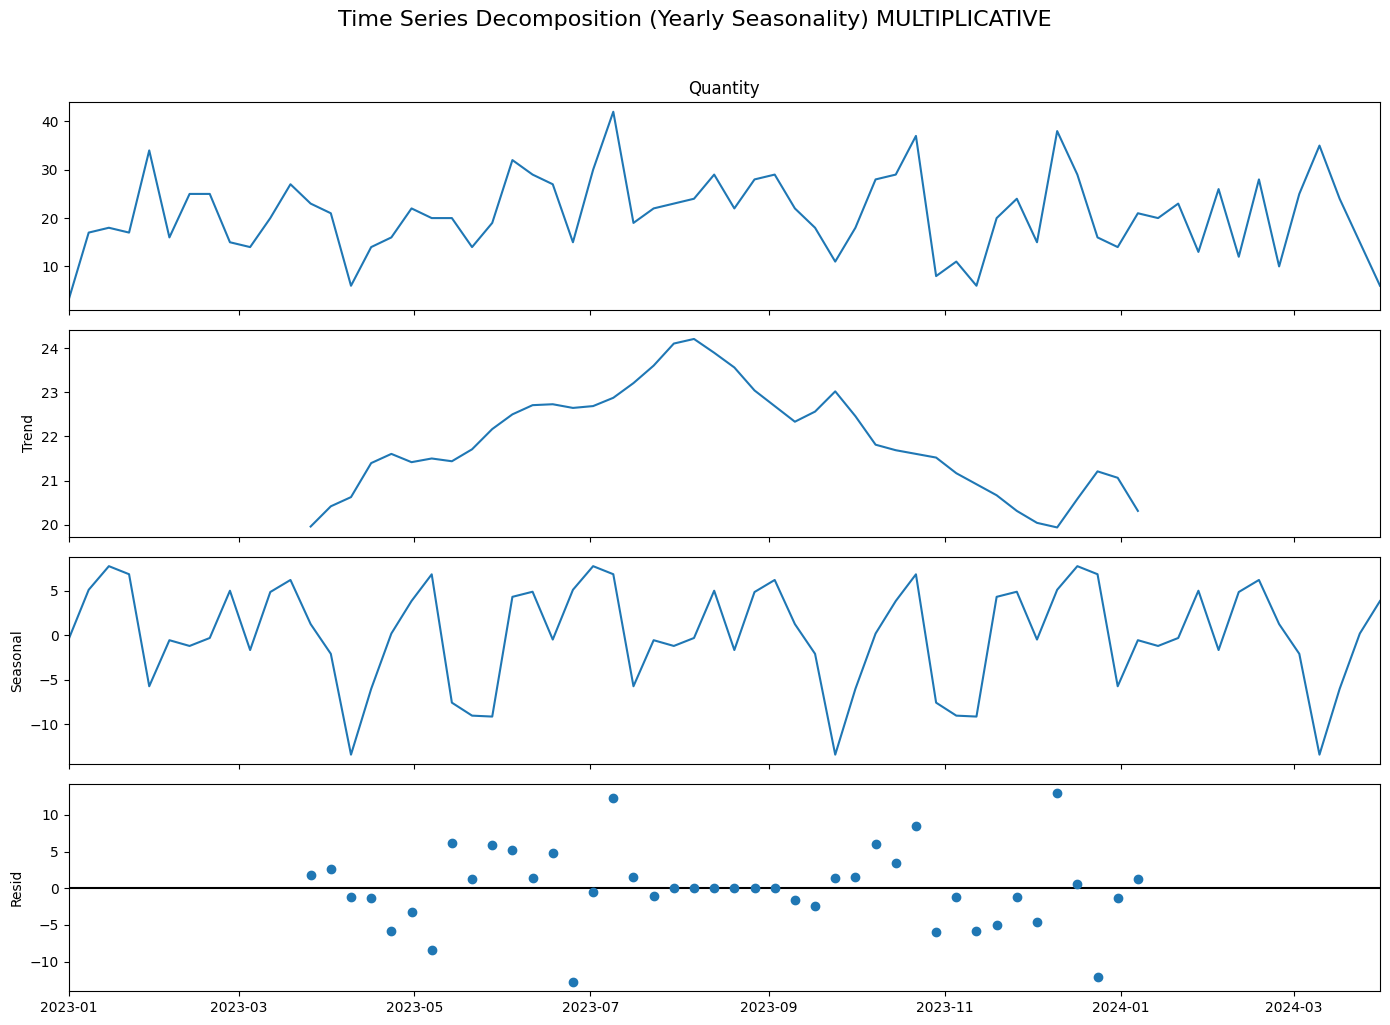

In [ ]:
decomposition = seasonal_decompose(df['Quantity'], model='adictive', period=24)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.suptitle('Time Series Decomposition (Yearly Seasonality) Adictive', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

**Temuan**:
- Trend: Menunjukkan pola naik dari 20 ke ~24 (pertengahan 2023), kemudian turun kembali ke ~20 di awal 2024
- Seasonality: Ada pola musiman tahunan yang cukup kuat dengan fluktuasi berkisar ±5 hingga ±15
- Residual: Tersebar relatif acak dengan beberapa outlier (±15), menandakan masih ada variasi yang belum tertangkap sepenuhnya oleh model dekomposisi

# Split Data Train dan Test

In [886]:
len_train = round(len(df) * 0.8)

df_close_train = df[:len_train]
df_close_test = df[len_train:]

print(f"total train: {len_train}")
print(f"total test: {len(df)-len_train}")

total train: 53
total test: 13


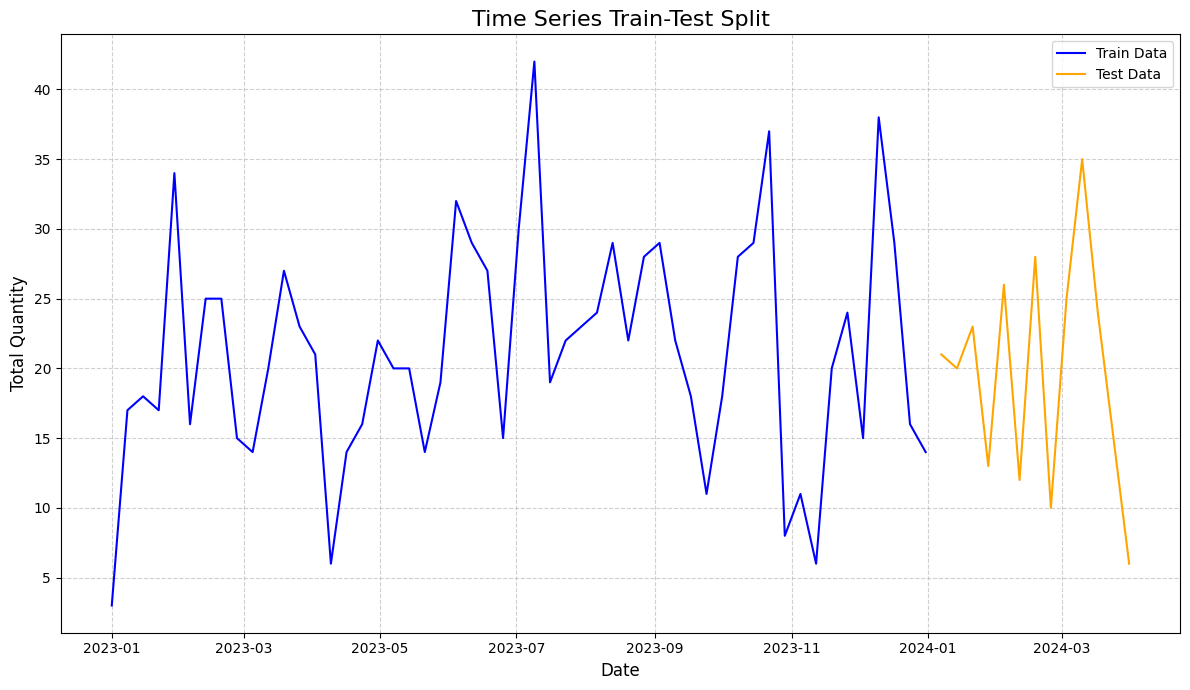

In [887]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(df_close_train.index, df_close_train['Quantity'], color='blue', label='Train Data')
ax.plot(df_close_test.index, df_close_test['Quantity'], color='orange', label='Test Data')
ax.set_title('Time Series Train-Test Split', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Quantity', fontsize=12)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Temuan**:
- Split dilakukan dengan baik, data training (biru) mencakup periode panjang (~Januari 2023 - Februari 2024)
- Test data (kuning) hanya ~2 bulan (Februari - April 2024)
- Data menunjukkan volatilitas tinggi dengan range 5-42

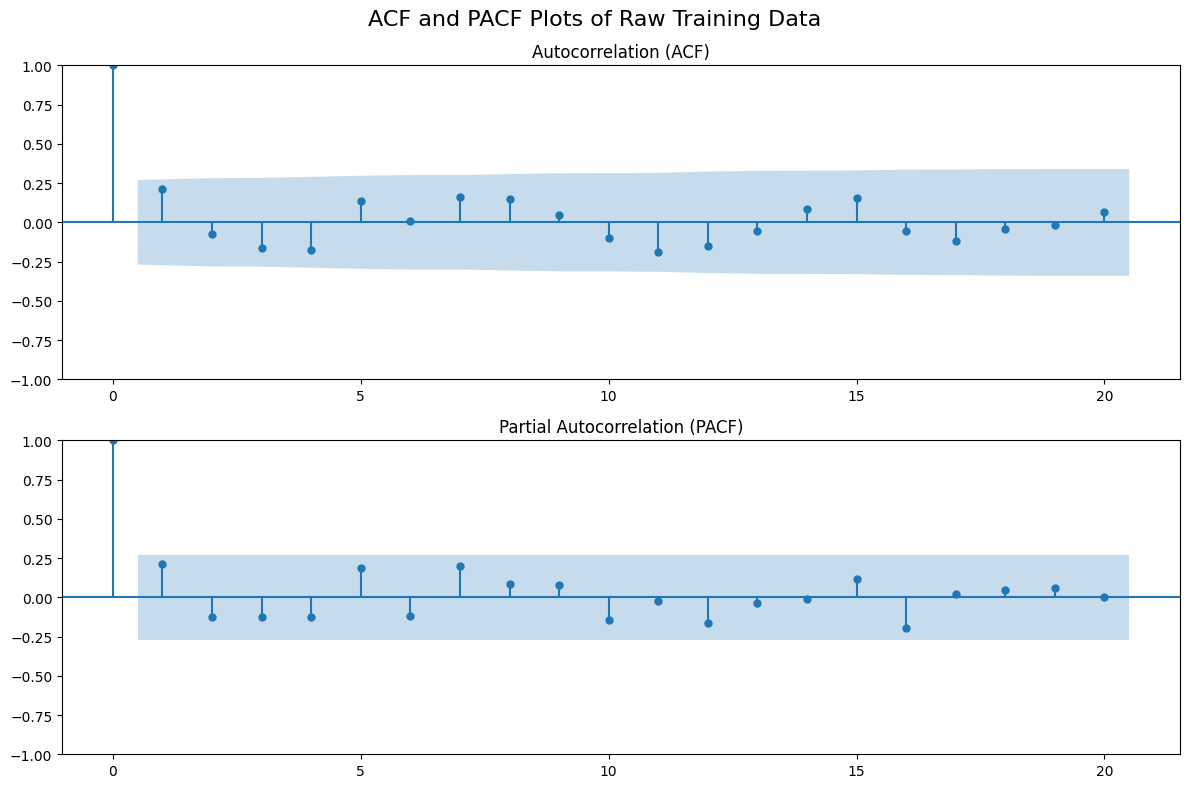

In [888]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle('ACF and PACF Plots of Raw Training Data', fontsize=16)
plot_acf(df_close_train['Quantity'], ax=ax1, lags=20)
ax1.set_title('Autocorrelation (ACF)')
plot_pacf(df_close_train['Quantity'], ax=ax2, lags=20)
ax2.set_title('Partial Autocorrelation (PACF)')
plt.tight_layout()
plt.show()

**Temuan**:
- ACF: Tidak ada spike signifikan di luar confidence interval setelah lag 0, menandakan data sudah cukup stasioner
- PACF: Beberapa spike kecil di lag 1, 5, 7, 15 - mengindikasikan kemungkinan komponen AR

Secara umum, data tampak sudah stasioner dan siap untuk modeling ARIMA



In [889]:
def perform_adf_test(series: pd.Series, series_name: str = "the series"):
    """
    Performs and prints the results of the Augmented Dickey-Fuller test.

    Args:
        series (pd.Series): The time series data to test.
        series_name (str): A descriptive name for the data being tested.
    """
    print(f"--- ADF Test Results for: {series_name} ---")

    # Perform the ADF test
    result = adfuller(series.dropna()) # dropna() is important for differenced series

    # Print the main results
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

    # Print the conclusion
    print('\n--- Conclusion ---')
    if result[1] <= 0.05:
        print("The data is likely stationary.")
    else:
        print("The data is likely non-stationary.")
    print("-" * 40)

In [890]:
perform_adf_test(df_close_train['Quantity'], series_name="Raw Training Data")

--- ADF Test Results for: Raw Training Data ---
ADF Statistic: -5.931661174663074
p-value: 2.3727051209614447e-07
Critical Values:
	1%: -3.562878534649522
	5%: -2.918973284023669
	10%: -2.597393446745562

--- Conclusion ---
The data is likely stationary.
----------------------------------------


In [891]:
def find_best_arima(data: pd.Series, p_range, d_order, q_range):
    """
    Performs a grid search to find the best ARIMA(p,d,q) order.

    Args:
        data (pd.Series): The time series data.
        p_range (range): A range of values for the AR order 'p'.
        d_order (int): The fixed differencing order 'd'.
        q_range (range): A range of values for the MA order 'q'.
    """
    best_aic = float('inf')
    best_order = None
    results = []

    for p in p_range:
        for q in q_range:
            order = (p, d_order, q)
            try:
                model = ARIMA(data, order=order)
                result = model.fit()

                results.append({'Order': order, 'AIC': result.aic})

                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = order

            except Exception as e:
                continue
    results_df = pd.DataFrame(results).sort_values('AIC').reset_index(drop=True)
    return results_df

In [892]:
p_values = range(0, 5)
d_value = 0
q_values = range(0, 5)

best_models_df = find_best_arima(df_close_train, p_values, d_value, q_values)

print("Top 5 ARIMA Models by AIC:")
print(best_models_df.head(10))

Top 5 ARIMA Models by AIC:
       Order         AIC
0  (1, 0, 1)  373.701190
1  (2, 0, 4)  374.826993
2  (1, 0, 4)  375.150020
3  (3, 0, 3)  375.210522
4  (0, 0, 1)  375.233999
5  (3, 0, 2)  375.615310
6  (1, 0, 0)  375.731967
7  (4, 0, 1)  375.967825
8  (0, 0, 4)  376.272198
9  (0, 0, 0)  376.501479


# Model

In [893]:
# Model definition
model = ARIMA(df_close_train, order = (1,0,1)) # (p,d,q)

# Model training
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Quantity   No. Observations:                   53
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -182.851
Date:                Wed, 10 Dec 2025   AIC                            373.701
Time:                        14:02:34   BIC                            381.582
Sample:                    01-01-2023   HQIC                           376.732
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.1370      1.378     15.340      0.000      18.436      23.838
ar.L1         -0.6967      0.147     -4.738      0.000      -0.985      -0.408
ma.L1          0.9997     11.020      0.091      0.928     -20.599      22.598
sigma2        55.5926    612.546      0.091      0.928   -1144.975    1256.160
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 0.47
Prob(Q):                              0.67   Prob(JB):                         0.79
Heteroskedasticity (H):               1.50   Skew:                            -0.23
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [904]:
train_predictions = result.predict(start=df_close_train.index[0], end=df_close_train.index[-1])
pred_train = pd.DataFrame(train_predictions, index=df_close_train.index)
pred_train.head()

,predicted_mean
2023-01-01,21.136957
2023-01-08,18.386231
2023-01-15,22.815381
2023-01-22,19.067356
2023-01-29,22.167196


In [905]:
train_concat = pd.concat([df_close_train, pred_train], axis=1)
train_concat.head()

,Quantity,predicted_mean
2023-01-01,3,21.136957
2023-01-08,17,18.386231
2023-01-15,18,22.815381
2023-01-22,17,19.067356
2023-01-29,34,22.167196


In [907]:
test_predictions = result.forecast(steps=len(df_close_test)) #step -> panjang data test
pred_test = pd.DataFrame(test_predictions)
pred_test.head()

,predicted_mean
2024-01-07,21.638054
2024-01-14,20.787857
2024-01-21,21.380165
2024-01-28,20.967521
2024-02-04,21.254998


In [908]:
pred_test.index = df_close_test.index
test_concat = pd.concat([df_close_test, pred_test], axis=1)
test_concat

,Quantity,predicted_mean
2024-01-07,21,21.638054
2024-01-14,20,20.787857
2024-01-21,23,21.380165
2024-01-28,13,20.967521
2024-02-04,26,21.254998
2024-02-11,12,21.054721
2024-02-18,28,21.194249
2024-02-25,10,21.097044
2024-03-03,25,21.164764
2024-03-10,35,21.117585


**Temuan**:
- Prediksi konsisten di range 20.7 - 21.6 (sangat stabil/flat)
- Tidak menangkap volatilitas tinggi yang ada di actual data (6-35)

In [909]:
mae_train = mean_absolute_error(df_close_train, train_predictions)
mae_test = mean_absolute_error(df_close_test, test_predictions)
print(f"Train MAE: {mae_train:.4f}")
print(f"Test MAE:  {mae_test:.4f}")

Train MAE: 6.0501
Test MAE:  6.5042


In [910]:
mae_train = mean_absolute_percentage_error(df_close_train, train_predictions)
mae_test = mean_absolute_percentage_error(df_close_test, test_predictions)
print(f"Train MAPE: {mae_train:.4f}")
print(f"Test MAPE:  {mae_test:.4f}")

Train MAPE: 0.4737
Test MAPE:  0.5111


**Temuan**:
- MAPE sangat tinggi (>50%) - Model tidak reliable untuk forecasting
- Prediksi terlalu smooth - Model hanya menangkap trend rata-rata, tidak menangkap volatilitas dan seasonality yang kuat
- Model kemungkinan under-fitting - Tidak cukup kompleks untuk menangkap pola data

# Kesimpulan

Berdasarkan hasil analisis, data yang tersedia masih terlalu minim untuk membangun model peramalan yang andal. Rentang nilai yang sangat volatil (5–42) dan pola musiman yang kuat membuat model menjadi terlalu sederhana serta berisiko menghasilkan prediksi yang kurang stabil. Dengan demikian, dibutuhkan data yang lebih panjang dan konsisten agar proses forecasting dapat memberikan hasil yang lebih akurat.”